# Semester Project in Distributed Algorithms by Raphael Duarte and Thomas Riedl

## Implementation of Distributed Depth-First-Search with gRPC and Docker

In [13]:
import yaml
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#own module
import dfs_containerization as dfs_con
import subprocess


# specify the graph of distributed nodes with edge list, all used nodes will be part of the graph
edge_list = [[1,7], [1,2], [1,4], [1,6],
             [2,1], [2,4], [2,3],
             [3,2], [3,4], [3,6], [3,5], [3,7], [3,8], [3,10],
             [4,1], [4,2], [4,3],[4,6], 
             [5,1], [5,3], [5,7],
             [6,4], [6,3], [6,10],
             [7,5], [7,3], [7,8],
             [8,3], [8,7],
             [10,3],[10,6]]

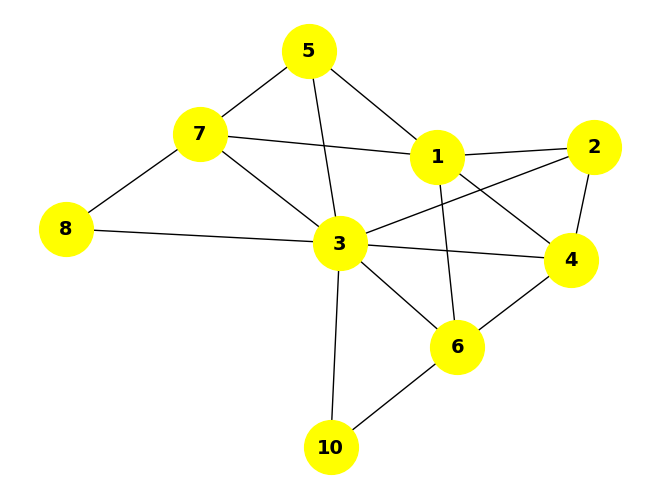

In [14]:
#plot the input graph
dfs_con.plot_input_graph(edge_list)

In [15]:
# create an overview of neigbours for each node of the graph and save result as "neighbours.yml"
dfs_con.get_neigbours_yaml(edge_list)

direct neighbours for each node:
{1: [7, 6, 5, 4, 2], 2: [4, 3, 1], 3: [10, 8, 7, 6, 5, 4, 2], 4: [6, 3, 2, 1], 5: [7, 3, 1], 6: [10, 4, 3, 1], 7: [8, 5, 3, 1], 8: [7, 3], 10: [6, 3]}


In [16]:
# specify which IP addresses should be used for the different containers in "ip_configuration.yml"
with open("ip_configuration.yml",'r') as file_ip:
    dict_ip = yaml.safe_load(file_ip)
    print("provided IP configuration for a graph of up to 10 nodes:")
    print(dict_ip)

provided IP configuration for a graph of up to 10 nodes:
{1: '172.20.0.11', 2: '172.20.0.12', 3: '172.20.0.13', 4: '172.20.0.14', 5: '172.20.0.15', 6: '172.20.0.16', 7: '172.20.0.17', 8: '172.20.0.18', 9: '172.20.0.19', 10: '172.20.0.20', 'subnet': '172.20.0.0/24'}


In [17]:
#Setup which port should be used for the gRPC communication between the nodes
PORT = 50051

# setup each node as docker container by generating a docker-compose file
nodes=dfs_con.write_docker_compose_yml(edge_list, PORT)

Initialization of Node 1:
{'build': {'context': '.', 'args': {'PORT': 50051, 'NODE_ID': 1}}, 'networks': {'frontend': {'ipv4_address': '172.20.0.11'}}, 'command': "/bin/sh -c 'python3 dfs_server.py'", 'container_name': 'node1', 'volumes': ['./output:/grpc-docker/ddfs/output']}


In [18]:
# build docker images of each Node according to generated docker-compose.yml file
process = subprocess.Popen(['docker-compose', 'build'], stdout=subprocess.PIPE, shell=True)
stdout = process.communicate()[0]
print(stdout.decode('utf-8'))


#1 [distributeddfs-n7 internal] load build definition from Dockerfile
#1 transferring dockerfile: 32B done
#1 DONE 0.0s

#2 [distributeddfs-n5 internal] load build definition from Dockerfile
#2 transferring dockerfile: 32B done
#2 DONE 0.0s

#3 [distributeddfs-n2 internal] load build definition from Dockerfile
#3 transferring dockerfile: 32B done
#3 DONE 0.0s

#4 [distributeddfs-n6 internal] load build definition from Dockerfile
#4 transferring dockerfile: 32B done
#4 DONE 0.0s

#5 [distributeddfs-n4 internal] load build definition from Dockerfile
#5 transferring dockerfile: 32B done
#5 DONE 0.0s

#6 [distributeddfs-n10 internal] load build definition from Dockerfile
#6 transferring dockerfile: 32B done
#6 DONE 0.0s

#7 [distributeddfs-n1 internal] load build definition from Dockerfile
#7 transferring dockerfile: 32B done
#7 DONE 0.0s

#8 [distributeddfs-n3 internal] load build definition from Dockerfile
#8 transferring dockerfile: 32B done
#8 DONE 0.0s

#9 [distributeddfs-n8 internal]

In [19]:
# start all created docker images as docker containers
# the protocol buffers are being built with start up
# the required code for DDFS is launched with start up (dfs_server.py)
process = subprocess.Popen(['docker-compose', 'up', '-d'], stdout=subprocess.PIPE, shell=True)
stdout = process.communicate()[0]
print(stdout.decode('utf-8'))


In [20]:
# start the DDFS on the root node
ROOT = 1
# enter the desired docker container and run dfs_client.py which will start the DDFS with the current node as root
process = subprocess.Popen(['docker', 'exec', 'node{}'.format(ROOT), 'python3', 'dfs_client.py'], stdout=subprocess.PIPE, shell=True)
stdout = process.communicate()[0]
print(stdout.decode('utf-8'))

Root:  1
Child: 10 Parent: 6
Child: 6 Parent: 4
Child: 8 Parent: 7
Child: 7 Parent: 5
Child: 4 Parent: 3
Child: 5 Parent: 3
Child: 3 Parent: 2
Child: 2 Parent: 1



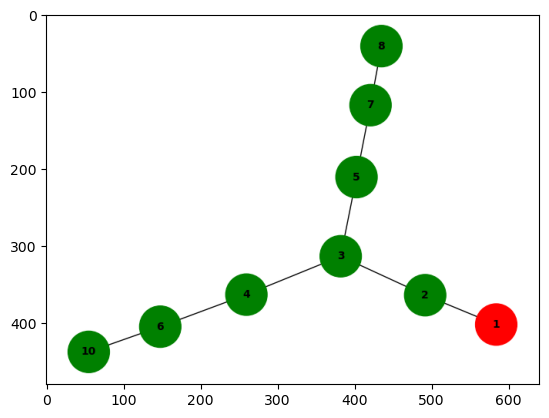

In [21]:
#plot the minimum spanning tree (saved in output/mst.png)
plt.imshow(plt.imread("../output/spanning_tree_root_{}.png".format(ROOT)))
plt.show()

Root:  5
Child: 10 Parent: 6
Child: 6 Parent: 4
Child: 8 Parent: 7
Child: 4 Parent: 3
Child: 7 Parent: 3
Child: 3 Parent: 2
Child: 2 Parent: 1
Child: 1 Parent: 5



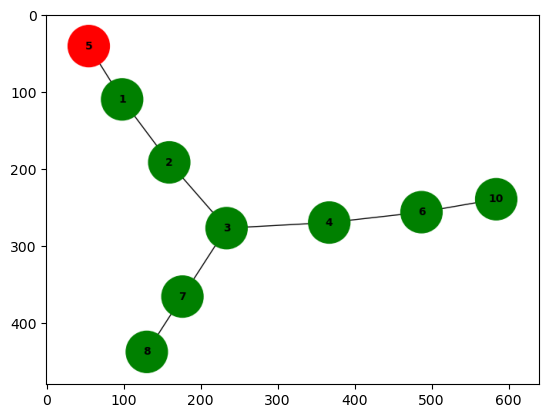

In [22]:
# use a different Node as Root
ROOT = 5
# enter the desired docker container and run dfs_client.py which will start the DDFS with the current node as root
process = subprocess.Popen(['docker', 'exec', 'node{}'.format(ROOT), 'python3', 'dfs_client.py'], stdout=subprocess.PIPE, shell=True)
stdout = process.communicate()[0]
print(stdout.decode('utf-8'))
#plot the minimum spanning tree (saved in output/mst.png)
plt.imshow(plt.imread("../output/spanning_tree_root_{}.png".format(ROOT)))
plt.show()

In [23]:
#kill the used docker containers
node_string = ''
for n in nodes:
    node_string = node_string + 'node{} '.format(int(n))
process = subprocess.Popen(['docker', 'kill', node_string], stdout=subprocess.PIPE, shell=True)
stdout = process.communicate()[0]
print(stdout.decode('utf-8'))
